In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

In [2]:
str1 = open('names.txt','r').read().splitlines()

In [3]:
allchars = sorted(list(set(''.join(str1))))

In [4]:
stoi = {s:i+1 for i,s in enumerate(allchars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
def set_giver(str1) :
    X,Y = [],[]
    block_size = 8
    for word in str1 :
        word = word + '.'
        context = [0]*block_size
        for ch in word :
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [6]:
X,Y = set_giver(str1)

In [7]:
import random
random.seed(42)
random.shuffle(str1)

str1_len = len(str1)

n1 = int(0.8*(str1_len))
n2 = int(0.9*(str1_len))

Xtr,Ytr = set_giver(str1[:n1])
Xdev,Ydev = set_giver(str1[n1:n2])
Xtest,Ytest = set_giver(str1[n2:])

In [8]:
Ytr.shape

torch.Size([182625])

In [9]:
class Linear:
    def __init__(self,fan_in,fan_out,bias = True):
        self.weight = torch.randn((fan_in,fan_out)) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None :
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [10]:
class BatchNorm1d:
    def __init__(self,dim,eps = 1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self,x):
        if x.ndim == 2 :
            dim = 0
        elif x.ndim == 3 :
            dim = (0,1)
        if self.training:
            xmean = x.mean(dim,keepdim = True)
            xvar = x.var(dim,keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xnext = (x-xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma*(xnext) + self.beta
        if self.training :
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var  = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    def parameters(self):
        return [self.gamma,self.beta]

In [11]:
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [12]:
class Embedding :
    def __init__(self,num_emb,emb_dim) :
        self.weight = torch.randn((num_emb,emb_dim))
    def __call__(self,X) :
        self.out = self.weight[X]
        return self.out
    def parameters(self) :
        return [self.weight]

In [13]:
class FlattenConsecutive :
    def __init__(self,n) :
        self.n = n
    def __call__(self,X) :
        B , T , C = X.shape
        X = X.view(B,T//self.n,self.n*C)
        if X.shape[1] == 1 :
            X = X.squeeze(1)
        self.out = X 
        return self.out
    def parameters(self) :
        return []

In [14]:
class Sequential :
    def __init__(self,layers) :
        self.layers = layers
    def __call__(self,X) :
        for layer in self.layers :
            X = layer(X)
        self.out = X
        return self.out
    def parameters(self) :
        return [p for layer in self.layers for p in layer.parameters()]

In [15]:
gen = torch.Generator().manual_seed(2147483647)

In [16]:
n_emb = 24
n_hidden = 128

vocab_size = 27
block_size = 8

step_size = 2

model = Sequential([
    Embedding(vocab_size,n_emb),
    FlattenConsecutive(step_size),Linear(n_emb*step_size,n_hidden,bias = False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(step_size),Linear(step_size*n_hidden,n_hidden,bias = False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(step_size),Linear(step_size*n_hidden,n_hidden,bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),
])

with torch.no_grad() :
     model.layers[-1].weight *= 0.1
     # for layer in layers[:-1] :
     #     if(isinstance(layer,Linear)) :
     #        layer.weight *= 5/3
     

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters :
    p.requires_grad = True

76579


In [17]:
Xtr.shape

torch.Size([182625, 8])

In [18]:
iterations = 200000
batch_size = 32

lossi = []

for i in range(iterations) :
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator = gen)
    X_batch = Xtr[ix]
    Y_batch = Ytr[ix]
    logits = model(X_batch)
    loss = F.cross_entropy(logits,Y_batch)

    for p in parameters :
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters :
        p.data += -lr * p.grad
        
    lossi.append(loss.item())
    if i % 1000 == 0 :
        print(f'epoch : {i}')

epoch : 0
epoch : 1000
epoch : 2000
epoch : 3000
epoch : 4000
epoch : 5000
epoch : 6000
epoch : 7000
epoch : 8000
epoch : 9000
epoch : 10000
epoch : 11000
epoch : 12000
epoch : 13000
epoch : 14000
epoch : 15000
epoch : 16000
epoch : 17000
epoch : 18000
epoch : 19000
epoch : 20000
epoch : 21000
epoch : 22000
epoch : 23000
epoch : 24000
epoch : 25000
epoch : 26000
epoch : 27000
epoch : 28000
epoch : 29000
epoch : 30000
epoch : 31000
epoch : 32000
epoch : 33000
epoch : 34000
epoch : 35000
epoch : 36000
epoch : 37000
epoch : 38000
epoch : 39000
epoch : 40000
epoch : 41000
epoch : 42000
epoch : 43000
epoch : 44000
epoch : 45000
epoch : 46000
epoch : 47000
epoch : 48000
epoch : 49000
epoch : 50000
epoch : 51000
epoch : 52000
epoch : 53000
epoch : 54000
epoch : 55000
epoch : 56000
epoch : 57000
epoch : 58000
epoch : 59000
epoch : 60000
epoch : 61000
epoch : 62000
epoch : 63000
epoch : 64000
epoch : 65000
epoch : 66000
epoch : 67000
epoch : 68000
epoch : 69000
epoch : 70000
epoch : 71000
epoch

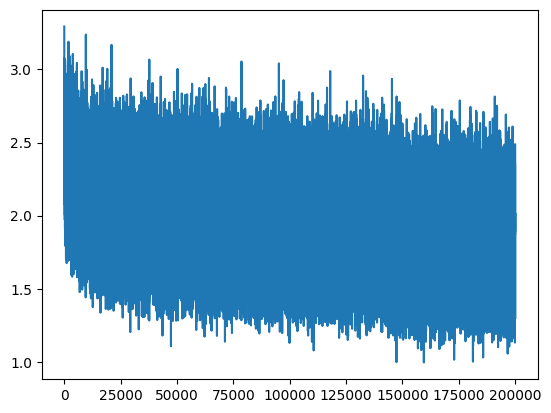

In [19]:
plt.plot(lossi)
plt.show()

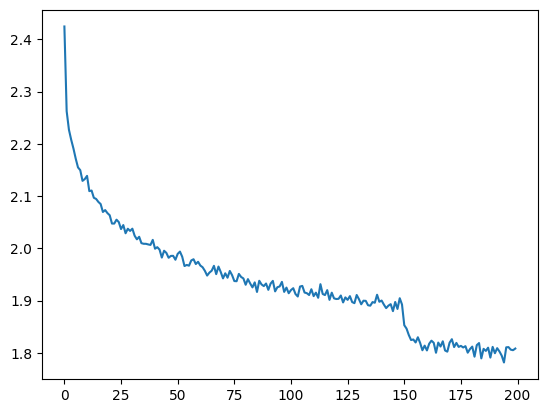

In [20]:
lossi_mod = torch.tensor(lossi).view(-1,1000).mean(1)
plt.plot(lossi_mod)

In [21]:
loss

tensor(1.8979, grad_fn=<NllLossBackward0>)

In [22]:
for layer in model.layers :
    layer.training = False

In [23]:
with torch.no_grad() :
    logits_dev = model(Xdev)
    loss_dev = F.cross_entropy(logits_dev,Ydev)
print("Dev loss : ",loss_dev.item())

Dev loss :  1.9895551204681396


In [53]:
with torch.no_grad() :
    logits_test = model(Xtest)
    loss_test = F.cross_entropy(logits_test,Ytest)
print("Test loss : ",loss_test.item())

Test loss :  1.9881478548049927


In [54]:
context = [0] * block_size
result = []
while True:
    logits_sample = model(torch.tensor([context]))
    probs = F.softmax(logits_sample,dim = 1)
    ix = torch.multinomial(probs,1,replacement = True).item()
    context = context[1:] + [ix]
    result.append(ix)
    if ix == 0 :
        break
print(''.join(itos[i] for i in result))

shrima.
